,$Hz$
fs0,"(0, 5)"
fc0,"(0, 75)"
fc1,30
fs1,50


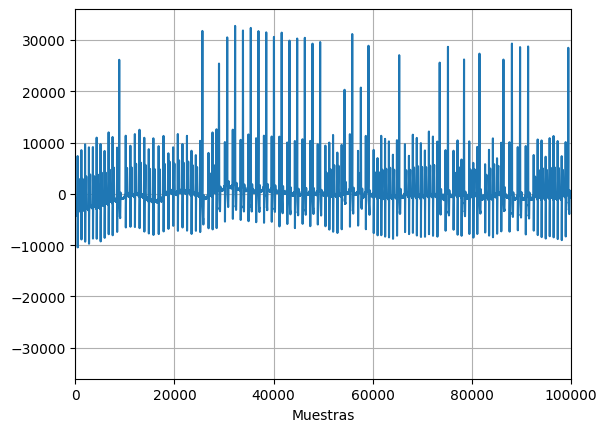

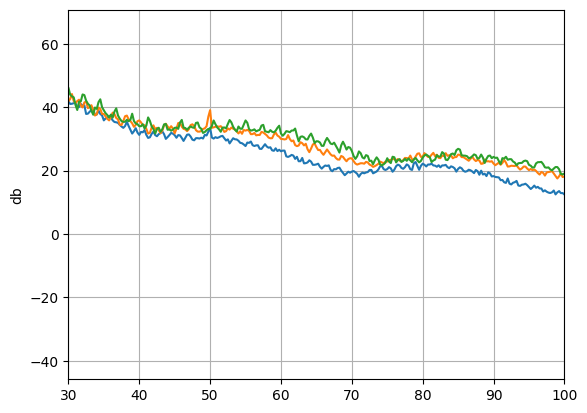

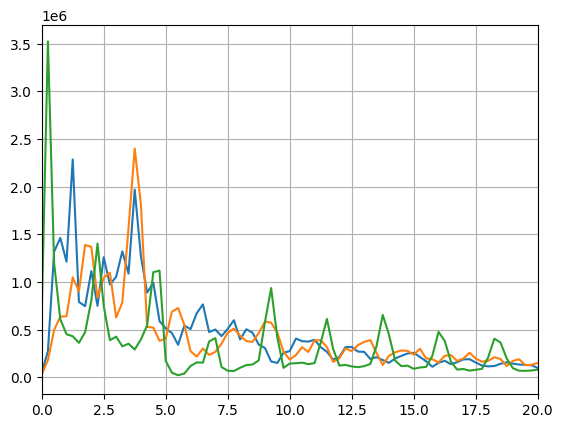

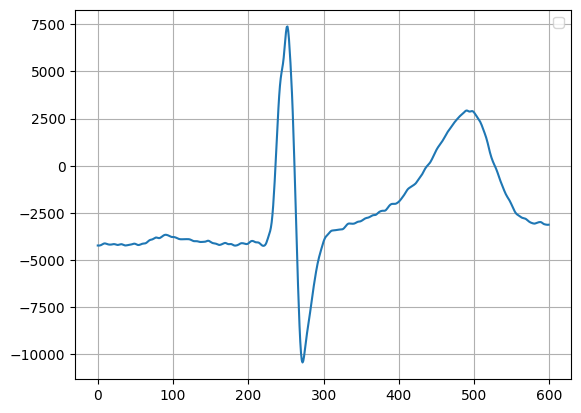

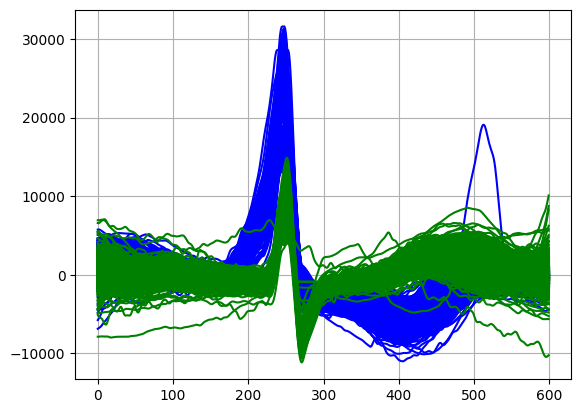

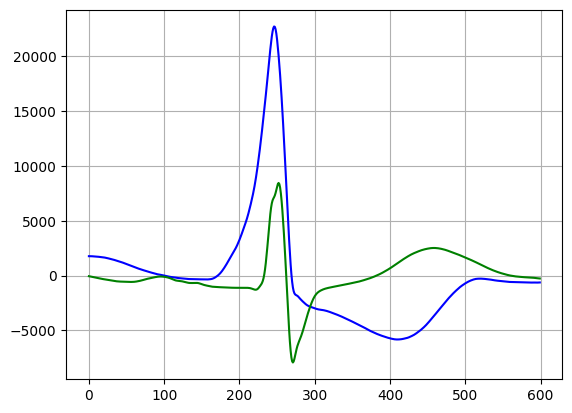

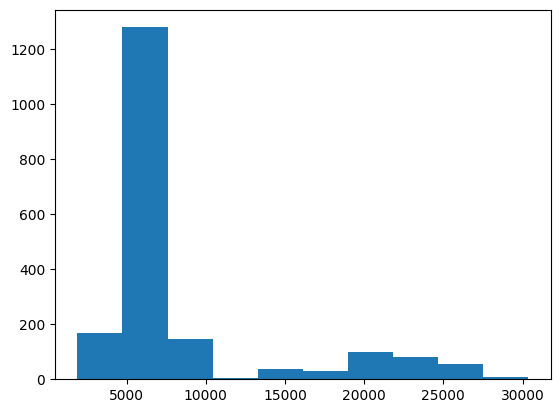

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  2 21:30:58 2022


@author: Guillermo Daniel Spagnolo
         daniespagnolo@frba.utn.edu.ar
"""

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io as sio 
from scipy import signal

from pandas import DataFrame
from IPython.display import HTML

#%%
N = 1000
fs= 1000# 1KHz frecuencia de sampling
Proporcion = 0.99#para el porcentaje de energia 
#resolution
block = (100,300,760,1000,4000)# definimos como tupla
#%% Carga de Archivo
mat_struct = sio.loadmat('ECG_TP4.mat')#cargamos el arhivo en mat_struct
ecg_one_lead = mat_struct['ecg_lead']#elegimos la estructura de ecg_lead del archivo

#%%Ploteo de la señal ECG
plt.figure(1)
plt.plot(ecg_one_lead,label='ECG')
plt.xlabel('Muestras')
plt.grid()
plt.xlim([0, 100000])

#%%       3 regiones de reposo,media  y alta intensidad 
#%%     Analisis de la ECG en distintos momentos
######################################
#     Reposo
ECG_reposo = ecg_one_lead[0:100000] #reposo

[f, PXX_pot_reposo] = signal.welch(ECG_reposo, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada= np.cumsum(PXX_pot_reposo)
#95 %de la energia 
#where genera una vector con la condicion
IndexEnergia= np.where(np.cumsum(PXX_pot_reposo)/EnergicaAcumulada[-1]>Proporcion)# 99 % 

W_corte0 = f[IndexEnergia[0]]#29 ciclos#95% energia en 29Hz
# PotW2/PotTot<=1
######################################
#     Ejercicio
###hay mas Energia en alta frecuencia
# ECG_Reposo= ecg_one_lead[300000:400000] #reposo seg 300 al 400 ~5mins
ECG_Ejercicio= ecg_one_lead[450000:550000]

[f, PXX_pot_ejercicio] = signal.welch(ECG_Ejercicio, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada= np.cumsum(PXX_pot_ejercicio)

IndexEnergia= np.where(np.cumsum(PXX_pot_ejercicio)/EnergicaAcumulada[-1]>Proporcion)

W_corte1 = f[IndexEnergia[0]]#32 ciclos
######################################
#     Pico Del Esfuerzo
#
ECG_Pico= ecg_one_lead[750000:850000]#PICO DEL ESFUERZO

[f, PXX_pot_PicoEsfuerzo] = signal.welch(ECG_Pico, fs=fs, nperseg = block[4],axis=0)

EnergicaAcumulada = np.cumsum(PXX_pot_PicoEsfuerzo)
# IndexEnergia= np.where(np.cumsum(PXX_pot_PicoEsfuerzo)/EnergicaAcumulada[-1]>95)# 95 % 
IndexEnergia = np.where(np.cumsum(PXX_pot_PicoEsfuerzo)/EnergicaAcumulada[-1]>Proporcion) 
W_corte2 = f[IndexEnergia[0]]#36 ciclos

#%%PLOTEOS COMPARATIVO REPOSO-EJERCICIO
# plt.legend('Algoritmado')
plt.figure(2)
##Logaritmico
plt.plot(f,10*np.log10((PXX_pot_reposo)),label='reposo')
plt.plot(f,10*np.log10((PXX_pot_ejercicio)),label='ejercicio')
plt.plot(f,10*np.log10((PXX_pot_PicoEsfuerzo)),label='Pico ')#en alta frecuencia 
plt.ylabel('db')
plt.xlim([30,100])
plt.grid()
#  2.2BPS 
#aparece un pico en baja frecuencia. se mete contaminacion por baja frecuencia      
#a partir de 30 se empiezan a separar

# plt.legend('Algoritmado')

#               Veces=watt/HZ
plt.figure(3) 
plt.plot(f,((PXX_pot_reposo)),label='reposo')
plt.plot(f,((PXX_pot_ejercicio)),label='ejercicio')
plt.plot(f,((PXX_pot_PicoEsfuerzo)),label='Pico')
#Aparece un movimiento de de baja frecuencia, producto del movimiento de linea de base que se incremento(aparece energia en baja frecuencia)
#aporte de energia nulo
plt.xlim([0,20])#Aparece un artefacto de visualizacion
plt.grid()
#%%
##Frec de latido reposo       = 1.2 
##Frec de latido ejercicio    = 1.8
##Frec de latido PicoEsfuerzo = 2.2
fs0 = 0,5  #fin de la banda de detenida 0#Frecuencia de corte inferior = 0.5 
fc0 = 0,75 #comienzo de la banda de paso 
fc1 = 30   #Fin de la banda de paso # Hz 
fs1 = 50   #Omega de Stop = 50Hz#porque es la primera interferencia clara

#%% Sacado muestral de un latido#%%Analisis de latidos de ancho fijo

##interferencias incorreladas tienen media nula
qrs_detections = mat_struct['qrs_detections']#un vector columna
inferior =250
superior =350
latido=(ecg_one_lead[int(qrs_detections[0]-inferior):int(qrs_detections[0]+superior)])#un latido solo, normal y ventricular
#Nos corremos un poco para la iizq y otro poco para la derecha
#Ploteo de un solo latido
plt.figure(4)
plt.legend('latido')    

plt.plot(latido)    
plt.grid()

# Sacado muestral de latidos 
latidos = np.zeros([superior+inferior,qrs_detections.shape[0]])#completo con cero 
muestras = np.arange(len(qrs_detections))

for nn in muestras:#de todas los latidos, saco de un ancho
    latidos[:,nn] = ecg_one_lead[int(qrs_detections[nn] - inferior):int(qrs_detections[nn] + superior )].flatten()
    latidos[:,nn] -= np.mean(latidos[:,nn])#Sacamos la media de latidos

#%% Diferenciar los latidos y separarlos            
EstimadorAmplitud = latidos[242,:]#agarro la muestra 242 
#11500 Diferencia los Ventriculares de los latidos Normales 
FiltroNormal=EstimadorAmplitud<11500

Ventricular=latidos[:,np.bitwise_not(FiltroNormal)]
Normal=latidos[:,FiltroNormal]
# Ventricular = np.where(EstimadorAmplitud>11500)[0]

# Ventricular=latidos[:,Ventricular]
plt.figure(5)
# plt.plot(latidos) 
plt.plot(Ventricular,'b',label='Ventricular')
plt.plot(Normal,'g',label = 'Normal')
plt.grid()

plt.figure(6)           
plt.plot(np.mean(Ventricular,axis=1),'b',label='Ventricular')
plt.plot(np.mean(Normal,axis=1),'g',label='Normal')
plt.grid()

plt.figure(7)
plt.hist(EstimadorAmplitud)             

PlantillaFiltro= [ 
                    [fs0], # fin banda stop
                    [fc0], # comienzo banda paso
                    [fc1], # fin banda paso
                    [fs1], # comienzo banda stop
                    
                  ]


In [3]:
df_integral = DataFrame(PlantillaFiltro, columns=['$Hz$', ],
                index=[  
                        'fs0',
                        'fc0',
                        'fc1',
                        'fs1'
                      ])
HTML(df_integral.to_html())


,$Hz$
fs0,"(0, 5)"
fc0,"(0, 75)"
fc1,30
fs1,50
